In [ ]:
# !pip install mlxtend
# !pip install imblearn

In [60]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import gensim
import numpy as np
import pandas as pd
from mlxtend.plotting import plot_decision_regions
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, auc, classification_report,
                             confusion_matrix, f1_score, roc_curve)
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
import copy
import time
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [10]:
df = pd.read_csv('labelled_data_1.csv', index_col=False)
df.drop(columns=['Unnamed: 0.1', 'Column1', 'Unnamed: 0'], inplace=True)

In [14]:
df.topic.value_counts(normalize=True)

topic
5    0.469724
2    0.110495
1    0.086741
3    0.075156
0    0.052083
4    0.049552
6    0.042835
9    0.042640
7    0.039622
8    0.031153
Name: proportion, dtype: float64

Классы в датасете не сбалансированы. 5 тема - 50% всего датасета.
1. Обращения
   1.1 Списания/денежные средства
   1.2 Проблемы с сим-меню
   1.3 Esim (проблемы подключения, код активации, qr-код)
   1.4 Проблемы с контентом и отключение услуг/ подписок/ сервисов
   1.5 Учетные записи
2. Информация
   2.6 Уведомления о технических работах
   2.7 Сбой работы (в работе оператора)
   2.8 Тесты, проблемы с доставкой, прочие тех. оповещения
3. Черный список
   3.9 Черный список
4. Спам
   4.10 Спам, реклама

## Word2Vec

In [37]:
w2v_model = gensim.models.Word2Vec.load("word2vec.model")

df.texts_cmb = df.texts_cmb.astype(str)
texts_tokenized = [text.split() for text in df['texts_cmb']]

In [70]:
def get_mean_vector(text):
    words = [w for w in text if w in w2v_model.wv]
    return np.mean(w2v_model.wv[words], axis=0) if words else np.zeros(w2v_model.vector_size)

df['mean_vector'] = df['texts_cmb'].apply(lambda x: get_mean_vector(x))

In [71]:
X = np.array([get_mean_vector(text) for text in df['texts_cmb']])
y = df['topic']

## SVM

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

In [97]:
# Посмотрим на рапределение классов в тесте и трейне
print('y_train', y_train.value_counts(normalize=True))
print('y_test', y_test.value_counts(normalize=True))

y_train topic
5    0.459112
2    0.114875
1    0.088006
3    0.073598
0    0.051012
4    0.050623
6    0.045950
7    0.042056
9    0.040109
8    0.034657
Name: proportion, dtype: float64
y_test topic
5    0.473261
2    0.109034
1    0.086319
3    0.075675
0    0.052440
4    0.049195
9    0.043484
6    0.041796
7    0.038811
8    0.029984
Name: proportion, dtype: float64


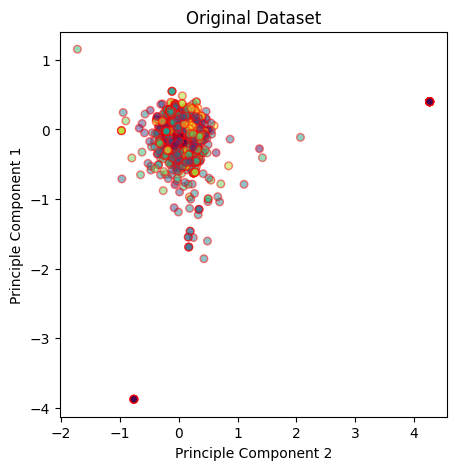

In [93]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Perform PCA Decomposition on both train and test sets
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

def plot_data(X,y,ax,title):
    ax.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, s = 30, edgecolor=(1, 0, 0, 0.5))
    ax.set_ylabel('Principle Component 1')
    ax.set_xlabel('Principle Component 2')
    if title is not None:
        ax.set_title(title)

# Plot dataset
fig,ax = plt.subplots(figsize=(5, 5))
plot_data(X_train_pca, y_train, ax, title='Original Dataset')

In [102]:
# Создаем модель SVM для многоклассовой классификации
svm_model = SVC(kernel='linear', decision_function_shape='ovr')

svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Точность классификации: {accuracy:.4f}")
print("\nОтчет о классификации:\n", classification_report(y_test, y_pred))

Точность классификации: 0.8293

Отчет о классификации:
               precision    recall  f1-score   support

           0       0.71      0.85      0.77       404
           1       0.75      0.91      0.82       665
           2       0.64      0.88      0.74       840
           3       0.64      0.71      0.67       583
           4       0.49      0.31      0.38       379
           5       0.99      0.99      0.99      3646
           6       0.83      0.56      0.67       322
           7       0.73      0.69      0.71       299
           8       0.82      0.69      0.75       231
           9       0.25      0.00      0.01       335

    accuracy                           0.83      7704
   macro avg       0.68      0.66      0.65      7704
weighted avg       0.81      0.83      0.81      7704



### Random Oversampling

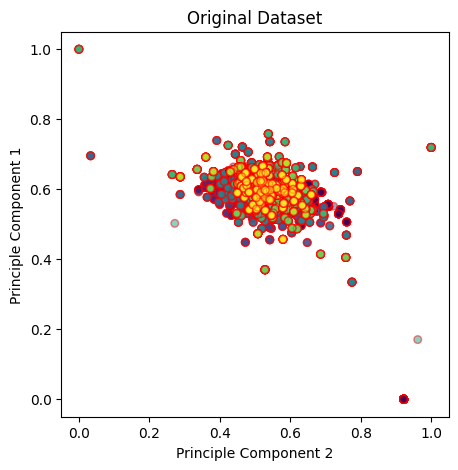

In [96]:
from imblearn.over_sampling import RandomOverSampler

# Perform random oversampling
ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

fig,ax = plt.subplots(figsize=(5, 5))
plot_data(X_train_ros, y_train_ros, ax, title='Original Dataset')

In [104]:
# Train SVC on randomly oversampled data
clf_ros = SVC(kernel='linear', decision_function_shape='ovr')
clf_ros.fit(X_train_ros, y_train_ros)
y_pred_ros = clf_ros.predict(X_test)


accuracy = accuracy_score(y_test, y_pred_ros)
print(f"Точность классификации: {accuracy:.4f}")
print("\nОтчет о классификации:\n", classification_report(y_test, y_pred_ros))

Точность классификации: 0.8422

Отчет о классификации:
               precision    recall  f1-score   support

           0       0.71      0.87      0.78       404
           1       0.82      0.86      0.84       665
           2       0.88      0.77      0.82       840
           3       0.79      0.67      0.73       583
           4       0.42      0.44      0.43       379
           5       0.99      0.96      0.97      3646
           6       0.71      0.68      0.69       322
           7       0.52      0.79      0.62       299
           8       0.80      0.82      0.81       231
           9       0.62      0.69      0.65       335

    accuracy                           0.84      7704
   macro avg       0.73      0.76      0.74      7704
weighted avg       0.86      0.84      0.85      7704



## Undersampling

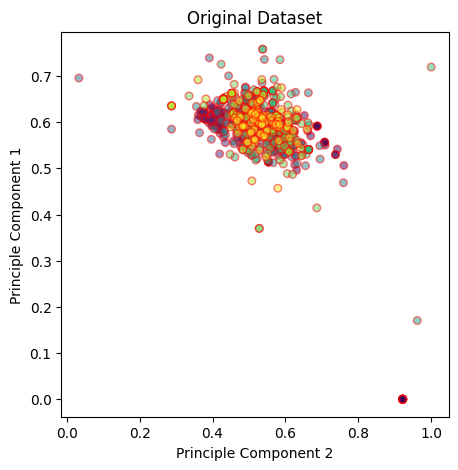

In [107]:
from imblearn.under_sampling import RandomUnderSampler

# Perform random sampling
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

fig,ax = plt.subplots(figsize=(5, 5))
plot_data(X_train_rus, y_train_rus, ax, title='Original Dataset')

In [108]:
# Train SVC on randomly undersampled data
clf_rus  = SVC(kernel='linear', decision_function_shape='ovr')
clf_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = clf_rus.predict(X_test)


accuracy = accuracy_score(y_test, y_pred_rus)
print(f"Точность классификации: {accuracy:.4f}")
print("\nОтчет о классификации:\n", classification_report(y_test, y_pred_rus))

Точность классификации: 0.8293

Отчет о классификации:
               precision    recall  f1-score   support

           0       0.59      0.88      0.70       404
           1       0.76      0.84      0.80       665
           2       0.87      0.68      0.76       840
           3       0.71      0.58      0.64       583
           4       0.38      0.40      0.39       379
           5       0.99      0.99      0.99      3646
           6       0.87      0.58      0.69       322
           7       0.63      0.72      0.67       299
           8       0.69      0.72      0.71       231
           9       0.62      0.69      0.65       335

    accuracy                           0.83      7704
   macro avg       0.71      0.71      0.70      7704
weighted avg       0.84      0.83      0.83      7704



## Class weights


In [109]:
# Train SVC on default data
clf_bal = SVC(kernel='linear', class_weight='balanced')
clf_bal.fit(X_train, y_train)
y_pred_rus = clf_bal.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rus)
print(f"Точность классификации: {accuracy:.4f}")
print("\nОтчет о классификации:\n", classification_report(y_test, y_pred_rus))

Точность классификации: 0.8229

Отчет о классификации:
               precision    recall  f1-score   support

           0       0.60      0.88      0.72       404
           1       0.78      0.85      0.81       665
           2       0.88      0.74      0.80       840
           3       0.76      0.63      0.69       583
           4       0.40      0.39      0.39       379
           5       0.99      0.96      0.97      3646
           6       0.72      0.57      0.64       322
           7       0.49      0.76      0.60       299
           8       0.76      0.71      0.73       231
           9       0.61      0.67      0.64       335

    accuracy                           0.82      7704
   macro avg       0.70      0.72      0.70      7704
weighted avg       0.84      0.82      0.83      7704



Наилучший результат показала модель на oversampled data - 0.8422